<a href="https://colab.research.google.com/github/Pareek-Yash/Optical-Character-Recognition-MNIST/blob/main/ocr_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import cv2
import time
import keras

In [2]:
import matplotlib as mpl

In [3]:
%matplotlib inline

## Importing The MNIST dataset

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


The MNIST is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. 

1. x_train: uint8 NumPy array of grayscale image data with shapes (60000,
28, 28), containing the training data. Pixel values range from 0 to 255.

2. y_train: uint8 NumPy array of digit labels (integers in range 0-9) with shape (60000,) for the training data.

3. x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data. Pixel values range from 0 to 255.

4. y_test: uint8 NumPy array of digit labels (integers in range 0-9) with shape (10000,) for the test data.

Let's look how our images actually look like

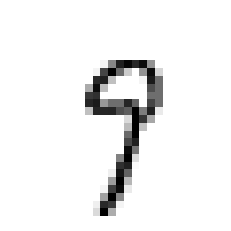

In [5]:
some_digit = x_train[1500]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [6]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [26]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10)
score = model.evaluate(x_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 99s 49ms/step - loss: 0.1839 - accuracy: 0.9506
Epoch 2/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0907 - accuracy: 0.9754
Epoch 3/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0756 - accuracy: 0.9796
Epoch 4/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0589 - accuracy: 0.9839
Epoch 5/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0482 - accuracy: 0.9867
Epoch 6/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0387 - accuracy: 0.9889
Epoch 7/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0383 - accuracy: 0.9893
Epoch 8/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0313 - accuracy: 0.9909
Epoch 9/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0266 - accuracy: 0.9920
Epoch 10/10
313/313 [==============================] - 4s 12ms/s

In [9]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 12ms/step - loss: 0.0288 - accuracy: 0.9919


In [54]:
y_pred = model.predict(x_test[:10])

1/1 [==============================] - 0s 20ms/step


In [56]:
predicted = np.array([np.argmax(prediction) for prediction in y_pred])

In [57]:
predicted

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [58]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)